First, import the necessary libraries and define our data paths:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from thefuzz import process
from empath import Empath 
from CoreNLPanalysis import *
%matplotlib inline
lexicon = Empath()

C:\Users\nerea\anaconda3\envs\ADA\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
C:\Users\nerea\anaconda3\envs\ADA\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
google_colab = False
if google_colab:
    data_folder = '/content/sample_data/'
else:
    data_folder = './Data/'

In [4]:
characters = pd.read_csv(data_folder + "character.metadata.tsv", sep='\t', header = None)
characters.columns = ('Wikipedia movie ID', 'Freebase movie ID', 'Movie release date',
              'Character name', 'Actor date of birth', 'Actor gender',
              'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 'Actor name', 
              'Actor age at movie release', 'Freebase character/actor map ID', 'Freebase character ID', 
              'Freebase actor ID')
characters['Movie release date'] = pd.to_datetime(characters['Movie release date'], errors = 'coerce').dt.year 
#change all formats to datetime

In [5]:
movies = pd.read_csv(data_folder + "movie.metadata.tsv", sep='\t', header = None)
movies.columns = ('Wikipedia movie ID' , 'Freebase movie ID' , 'Movie name' , 
                'Movie release date' , 'Movie box office revenue' , 
                'Movie runtime' , 'Movie languages' , 'Movie countries' , 'Movie genres')

movies['Movie release date'] = pd.to_datetime(movies['Movie release date'], errors = 'coerce').dt.year
# change all formats to datetime and keep the year only


In [6]:
# Loading plot summaries
df_plot_summaries = pd.read_csv('Data/plot_summaries.txt', sep='\t')
df_plot_summaries.columns = ['Wikipedia movie ID', 'Plot Summary']
print(len(df_plot_summaries))

42302


**Note:** : Many of the date formats are inconsistent. Here we convert it all to just year as this is the temporal resolution in which we are interested

In [7]:
movies.sample(3)

Wikipedia movie ID Freebase movie ID            Movie name  \
42854            19493519        /m/04mzyly        Tyrannens fald   
7363             27174904        /m/0bwjlrw      The Man Upstairs   
47635              722340         /m/035pnb  Dynasty: The Reunion   

       Movie release date  Movie box office revenue  Movie runtime  \
42854              1942.0                       NaN           88.0   
7363               1958.0                       NaN           88.0   
47635              1991.0                       NaN          178.0   

                          Movie languages  \
42854     {"/m/0295r": "Danish Language"}   
7363   {"/m/02h40lc": "English Language"}   
47635  {"/m/02h40lc": "English Language"}   

                                 Movie countries  \
42854                    {"/m/0k6nt": "Denmark"}   
7363              {"/m/07ssc": "United Kingdom"}   
47635  {"/m/09c7w0": "United States of America"}   

                                            Movie genres  
42854  {"/m/0hqxf": "Family Film", "/m/01g6gs": "Blac...  
7363                             {"/m/07s9rl0": "Drama"}  
47635                            {"/m/07s9rl0": "Drama"}

In [8]:
print('There are {} entries in the movies dataset'.format(len(movies)))

There are 81741 entries in the movies dataset


In [9]:
for name, values in movies.items():
    print ('{:.4} % of movies have an associated {}'.format(100 * len(values.loc[values.notnull()])/len(values), name))

100.0 % of movies have an associated Wikipedia movie ID
100.0 % of movies have an associated Freebase movie ID
100.0 % of movies have an associated Movie name
91.56 % of movies have an associated Movie release date
10.28 % of movies have an associated Movie box office revenue
74.98 % of movies have an associated Movie runtime
100.0 % of movies have an associated Movie languages
100.0 % of movies have an associated Movie countries
100.0 % of movies have an associated Movie genres


**Note :** Any analysis based on the movie revenue (as a measure of success) will need extra information, as probably basing the study only in 10% of the data is not enough.



In [ ]:
fig, ax = plt.subplots()
ax = movies['Movie release date'].hist(bins = range(1880,2030,10), grid = True, xlabelsize = 8 ,xrot = 45)
plt.xlabel('Year of Release')
plt.ylabel('Number of movies')
plt.title('Movies released over the Decades');

**Note:** On 16 December 2014, Google announced that it would shut down Freebase over the succeeding six months and help with the move of the data from Freebase to Wikidata. Data collection does not go through the entire 2010's decade

In [115]:
print('The dataset is comprised of movies with known releases between {0:n} and {1:n} '.format(movies['Movie release date'].min(), 
                                                                                               movies['Movie release date'].max()))

The dataset is comprised of movies with known releases between 1888 and 2016 


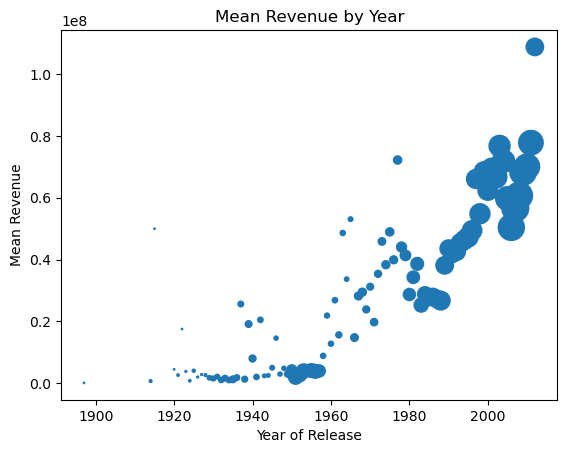

In [116]:
r_by_year = rmovies.groupby("Movie release date")['Movie box office revenue'].agg(['mean','size']).reset_index()
r_by_year.plot(kind = 'scatter', x = 'Movie release date', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year')
plt.ylabel('Mean Revenue')
plt.xlabel('Year of Release');

From the above plot we see that the mean revenues increase over time. It would be interesting to normalize this by inflation or perhaps some share of GDP. We also see that there is much more data present in the later years (dot size scaled by amount of revenues averaged to form datapoint. 1897 - 1 movie revenue, 2008 - 367 movie revenues)

In [127]:
def correct_countries(x):
    if len(x)>2:
        x= x.split(':')[1][0:-1]
        res = x.split('"')[1]
    else:
        res = 'NA' 
    return res

movies["Movie countries corrected"]= movies["Movie countries"].apply(lambda x: correct_countries(x))

In [178]:
c_movies_filt = pd.DataFrame(movies.groupby(["Movie release date","Movie countries corrected"]).size()).reset_index()
c_movies_filt = c_movies_filt.set_axis(["Movie release date", "Movie countries corrected", 'Count'], axis='columns', copy=False)
c_movies_filt.tail(10)

Movie release date Movie countries corrected  Count
4104              2013.0  United States of America     94
4105              2014.0                 Australia      1
4106              2014.0                     India      3
4107              2014.0                        NA      8
4108              2014.0            United Kingdom      1
4109              2014.0  United States of America      4
4110              2015.0                        NA      2
4111              2015.0  United States of America      2
4112              2016.0                        NA      1
4113              2016.0  United States of America      2

In [179]:
most_common_count = movies.groupby(["Movie countries corrected"]).size().reset_index()
most_common_count = most_common_count.set_axis(["Country", "Number of movies"], axis='columns')
most_common_count.drop(most_common_count[most_common_count['Country'] == 'NA'].index, inplace = True)
most_common_count = most_common_count.sort_values("Number of movies", ascending=False)[0:10]
most_common_count

Country  Number of movies
124  United States of America             34118
51                      India              8294
123            United Kingdom              5477
40                     France              3996
60                      Japan              2321
58                      Italy              1925
21                     Canada              1471
3                   Argentina              1291
48                  Hong Kong              1120
5                   Australia               874

In [180]:
top10_country_data = c_movies_filt[c_movies_filt['Movie countries corrected'].isin(most_common_count['Country'])]

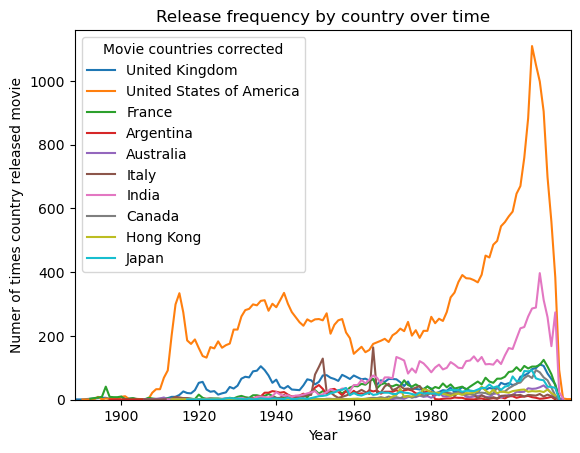

In [181]:
sns.lineplot(x='Movie release date', y='Count',data = top10_country_data, hue = 'Movie countries corrected', legend=True)
plt.xlabel("Year")
plt.ylabel("Numer of times country released movie")
plt.title("Release frequency by country over time")
plt.ylim([0,top10_country_data['Count'].max()+50])
plt.xlim([top10_country_data['Movie release date'].min(), top10_country_data['Movie release date'].max()]);
#plt.yscale('log')

In [182]:
characters.sample(3)

Wikipedia movie ID Freebase movie ID Movie release date  \
3223              20426704        /m/04zzqht               1999   
17850             12419099        /m/02w4l38         1953-04-10   
178218             1179229         /m/04dx1c         1983-12-09   

       Character name Actor date of birth Actor gender  \
3223              NaN          1967-06-27            M   
17850             NaN          1888-12-08            M   
178218            NaN                 NaN          NaN   

        Actor height (in meters) Actor ethnicity (Freebase ID)  \
3223                         NaN                      /m/0j6x8   
17850                        NaN                           NaN   
178218                       NaN                           NaN   

                Actor name  Actor age at movie release  \
3223    David Ngoombujarra                        31.0   
17850        Paul Cavanagh                         NaN   
178218          Paul Drake                         NaN   

       Freebase character/actor map ID Freebase character ID Freebase actor ID  
3223                        /m/09j1wk8                   NaN        /m/02zbgy4  
17850                       /m/09j06qs                   NaN        /m/03gw1kz  
178218                      /m/0gbztzm                   NaN        /m/0gbztzr

In [183]:
print('There are {} entries in the characters dataset'.format(len(characters)))

There are 450669 entries in the characters dataset


In [184]:
for name, values in characters.items():
    print ('{:.4} % of characters have an associated {}'.format(100 * len(values.loc[values.notnull()])/len(values), name))

100.0 % of characters have an associated Wikipedia movie ID
100.0 % of characters have an associated Freebase movie ID
97.78 % of characters have an associated Movie release date
42.78 % of characters have an associated Character name
76.45 % of characters have an associated Actor date of birth
89.88 % of characters have an associated Actor gender
34.35 % of characters have an associated Actor height (in meters)
23.53 % of characters have an associated Actor ethnicity (Freebase ID)
99.73 % of characters have an associated Actor name
64.92 % of characters have an associated Actor age at movie release
100.0 % of characters have an associated Freebase character/actor map ID
42.78 % of characters have an associated Freebase character ID
99.82 % of characters have an associated Freebase actor ID


In [234]:
char_filt_age = characters[characters['Actor age at movie release'].notnull()]
#we see lots of NA ages at release... lets drop those

In [235]:
char_filt_age.loc[char_filt_age['Actor age at movie release']<0]

Wikipedia movie ID Freebase movie ID  Movie release date  \
767               15007384        /m/03h4h5p              1934.0   
2286               2553539         /m/07mlsy              1918.0   
3892               5917218         /m/0fdf3y              1965.0   
6666                 73930          /m/0jsjm              1924.0   
7188              21242801        /m/05bzjwj              1955.0   
...                    ...               ...                 ...   
446570             3642891         /m/09rsyj              1999.0   
446581            25868401        /m/09v6ykm              1955.0   
446583             8595532        /m/02799cv              1944.0   
446816             1276915         /m/04pg6m              1941.0   
447210            23382222        /m/06w1hlj              1932.0   

       Character name Actor date of birth Actor gender  \
767               NaN          1963-11-07          NaN   
2286              NaN          1931-03-25            M   
3892              NaN          1983-03-03            F   
6666           Robert          1972-11-07            M   
7188              NaN          1973-08-01            M   
...               ...                 ...          ...   
446570           Tess          2936-12-24            F   
446581            NaN          1967-05-31            F   
446583            NaN          1947-05-28            M   
446816            NaN          1957-04-19            M   
447210            NaN          1942-02-08            M   

        Actor height (in meters) Actor ethnicity (Freebase ID)  \
767                          NaN                           NaN   
2286                         NaN                           NaN   
3892                        1.75                           NaN   
6666                        1.80                           NaN   
7188                        1.79                     /m/03ttfc   
...                          ...                           ...   
446570                       NaN                           NaN   
446581                      1.67                     /m/03ts0c   
446583                       NaN                           NaN   
446816                       NaN                           NaN   
447210                       NaN                      /m/041rx   

               Actor name  Actor age at movie release  \
767         Franck Dubosc                       -29.0   
2286           Tom Wilson                       -12.0   
3892            Kim Smith                       -18.0   
6666         Jason London                       -48.0   
7188      Eduardo Noriega                       -17.0   
...                   ...                         ...   
446570        J.J. McColl                      -937.0   
446581  Sandrine Bonnaire                       -12.0   
446583       Kevin O'Shea                        -3.0   
446816        Tony Martin                       -15.0   
447210       Robert Klein                        -9.0   

       Freebase character/actor map ID Freebase character ID Freebase actor ID  
767                         /m/0bwb9k3                   NaN        /m/01wlly9  
2286                         /m/0jsqm1                   NaN         /m/0382zh  
3892                        /m/04mb5kf                   NaN         /m/03pjkv  
6666                        /m/01xrptw            /m/02nwfsk         /m/04kdmg  
7188                        /m/0cg2f0f                   NaN         /m/0bkkw0  
...                                ...                   ...               ...  
446570                      /m/0l2rdfz            /m/0l2rdg1        /m/0l2rdg8  
446581                      /m/04j05tr                   NaN         /m/07wn_5  
446583                      /m/02vcqnq                   NaN        /m/02q384f  
446816                      /m/0cg164j                   NaN         /m/07q_fg  
447210                      /m/0cg08dz                   NaN         /m/02pb53  

[381 rows x 13 columns]

**Note:** In the dataframe above we see 381 instances of negative ages. By taking the difference between the actor DOB and movie release date we realize that the actor age is correct in magnitude but not in sign. Below, we correct the column by taking its absolute value.

In [236]:
char_filt_age.loc[char_filt_age['Actor age at movie release'] < 0, 
                  'Actor age at movie release'] = char_filt_age['Actor age at movie release'].abs()

In [237]:
print('Only {:.4} % of charactors have an associated actor age at release'.format(100 * len(char_filt_age)/len(characters)))

Only 64.92 % of charactors have an associated actor age at release


In [238]:
char_age_grouped = char_filt_age.groupby(["Movie release date", "Actor gender"])['Actor age at movie release'].agg(['mean','size']).reset_index()


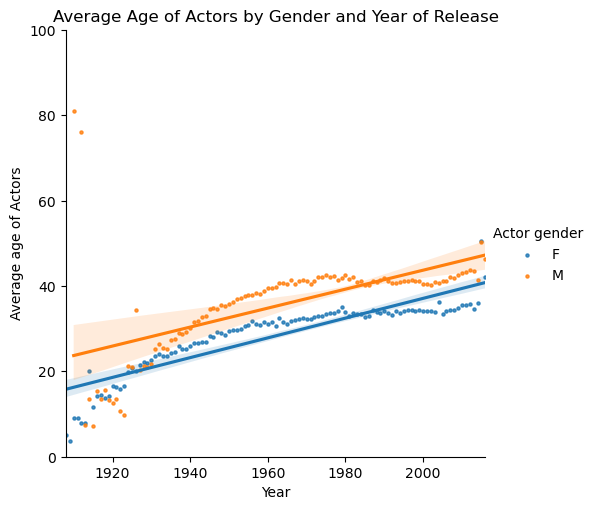

In [239]:
# Here we break down the analysis by gender, 

sns.lmplot(x="Movie release date", y='mean',data = char_age_grouped, hue = 'Actor gender', scatter_kws={"s":5})
plt.xlabel("Year")
plt.ylabel("Average age of Actors")
plt.title("Average Age of Actors by Gender and Year of Release")
plt.ylim([0,100])
plt.xlim([char_age_grouped["Movie release date"].min(),char_age_grouped["Movie release date"].max()]);

In [245]:
avg_age_M = round(char_filt_age.loc[char_filt_age['Actor gender'] == 'M']['Actor age at movie release'].mean(),0)
avg_age_F = round(char_filt_age.loc[char_filt_age['Actor gender'] == 'F']['Actor age at movie release'].mean(),0)
print('The average age for male actors is ', avg_age_M, ', whereas for actresses it is ', avg_age_F)

The average age for male actors is  40.0 , whereas for actresses it is  33.0


In the above figure we are displaying the average age at movie release for female and male actors, as well as the linear regression of the average age evolution over time. The shaded areas represent the 95% confidence interval for the regression.

It is interesting to note that males tend to be older than women in cinema over the last hundred years (at least since 1940). This difference observed in the plot is also confirmed by the computed overall average age at realease for both genders (40 for men compared to 33 for women). 

We can also observe a tendency to employ older actors in movies. One of the hypothesis for this fact is that the age at release data is lacking for older actors at the beginning of the 20th century. Record keeping was not as good as it is now. This could be an explanation for the fact that the data we do have on actors with roles in the early 20th century are all quite young - ie they lived long enough to enter modern database management. 

In [290]:
char_gen = pd.DataFrame(characters.groupby(['Movie release date', 'Actor gender'])['Actor gender'].agg('size')).rename(columns={'Actor gender' : 'Count'}).reset_index()
char_gen['Gender Percentage'] = char_gen['Count'] / char_gen.groupby('Movie release date')['Count'].transform('sum')*100
char_gen = char_gen.loc[char_gen['Actor gender'] == 'F']
char_gen.head()

Movie release date Actor gender  Count  Gender Percentage
0               1888.0            F      2          50.000000
4               1894.0            F      1          25.000000
7               1896.0            F      5          55.555556
9               1897.0            F      2          66.666667
11              1898.0            F      1          25.000000

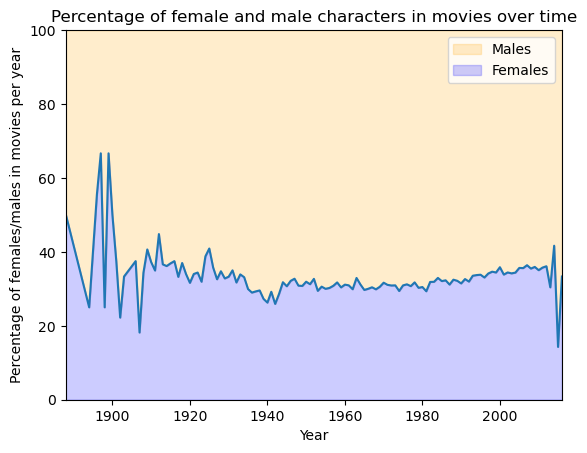

In [367]:
ax = sns.lineplot(x='Movie release date', y='Gender Percentage',data = char_gen, legend=True)
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, 100, color="orange", alpha=0.2, label = 'Males')

ax.fill_between(x1, y1, color="blue", alpha=0.2, label = 'Females')
plt.xlabel("Year")
plt.ylabel("Percentage of females/males in movies per year")
plt.title("Percentage of female and male characters in movies over time")
plt.ylim([0,100])
plt.xlim([char_gen['Movie release date'].min(), char_gen['Movie release date'].max()])
plt.legend()

#plt.yscale('log')

In [341]:
# Checking when either character name or Freebase movie ID are missing:
print('Missing "character names" in character metadata: %d' %characters['Character name'].isnull().sum())
print('Missing "Freebase character" IDs in character metadata: %d' %characters['Freebase character ID'].isnull().sum())
print('We can see that the number of missing character names ≈ missing Freebase character IDs')
print('There are 10 characters where we have a "Freebase character ID" but not "character names"')
# Checking when both "Character name" and "Freebase character ID are missing":
characters.loc[characters['Character name'].isnull() & characters['Freebase movie ID'].isnull()]
missing_both_IDs = sum(characters.iloc[:, [3, 11]].isnull().all(1))
print('Missing Character name AND Freebase character ID: %d' %missing_both_IDs)
# Checking characters for which we don't have that character name buit we have both the Freebase character/actor map ID and Freebase actor ID
characters.iloc[:, [3, 11]].isnull().all(1) # 4th column and 11th column
poss_recov = sum(characters.iloc[:, [3]].isnull().all(1) & characters.iloc[:, [10, 12]].notnull().all(1))
print('Missing character name but known Freebase character/actor map ID and Freebase actor ID: %d' %poss_recov)

Missing "character names" in character metadata: 257875
Missing "Freebase character" IDs in character metadata: 257865
We can see that the number of missing character names ≈ missing Freebase character IDs
There are 10 characters where we have a "Freebase character ID" but not "character names"
Missing Character name AND Freebase character ID: 257865
Missing character name but known Freebase character/actor map ID and Freebase actor ID: 257389


The previous analysis highlights the possibility of using the available Freebase IDs in order to recover a substantial amount to character names. The Freebase character/actor map will link the Freebase actor ID to the roles that the specific actor will have performed. As a result, we will be able to extract the Freebase character IDs, thus the missing character names. 

In [334]:
''' Merging character with movie metadata with an inner join. We do an inner join 
because there are movies in the movie metadata for which we do not 
have any character information in character metadata and vice versa.
For the future analysis we need both information about the characters
and movie in which they appear'''

df_char_movie = pd.merge(left= characters, right= movies, how='inner', on= ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date'])
print('The total number of characters that we obtain from the inner merge is: %d' %len(df_char_movie))

The total number of characters that we obtain from the inner merge is: 450669


In [335]:
movies_with_characters = df_char_movie.groupby(['Wikipedia movie ID']).agg('size')
print('The resulting number of movies from the merge of characters and movies is: %d'%len(movies_with_characters))

The resulting number of movies from the merge of characters and movies is: 64330


In [336]:
# Computing the total number of characters and the number of character names we have in our dataframe
char_names_per_movie = df_char_movie.groupby('Wikipedia movie ID')['Character name'].count() # extracts number of characters we have (i.e. not coun ting NaNs)
total_characters_per_movie = df_char_movie.groupby(['Wikipedia movie ID'])['Character name'].agg(['size'])

In [337]:
df_character_missing_stats = pd.merge(total_characters_per_movie, char_names_per_movie, on='Wikipedia movie ID')
df_character_missing_stats['n°_missing_characters'] = df_character_missing_stats['size'] - df_character_missing_stats['Character name']
df_character_missing_stats['percentage_missing'] = round(100 * df_character_missing_stats['n°_missing_characters'] / df_character_missing_stats['size'], 2) # computing percentages of missing character names
df_character_missing_stats['percentage_available'] = 100 - df_character_missing_stats['percentage_missing']
df_character_missing_stats = df_character_missing_stats.rename(columns={'size': 'total_n°_characters (incl. NaN)'})
df_character_missing_stats = df_character_missing_stats.rename(columns={'Character name': 'character_names (excl. NaN)'})
df_character_missing_stats.head()

total_n°_characters (incl. NaN)  \
Wikipedia movie ID                                    
330                                               4   
3217                                             14   
3333                                             14   
3746                                             15   
3837                                             20   

                    character_names (excl. NaN)  n°_missing_characters  \
Wikipedia movie ID                                                       
330                                           0                      4   
3217                                         14                      0   
3333                                          0                     14   
3746                                         15                      0   
3837                                         16                      4   

                    percentage_missing  percentage_available  
Wikipedia movie ID                                            
330                              100.0                   0.0  
3217                               0.0                 100.0  
3333                             100.0                   0.0  
3746                               0.0                 100.0  
3837                              20.0                  80.0

In the dataframe above we obtain:
- the total amount of characters in a specific movie
- the number of character names for a specific movie
- the percentage of the character names that are missing per movie
- the percentage of the character names that are available per movie

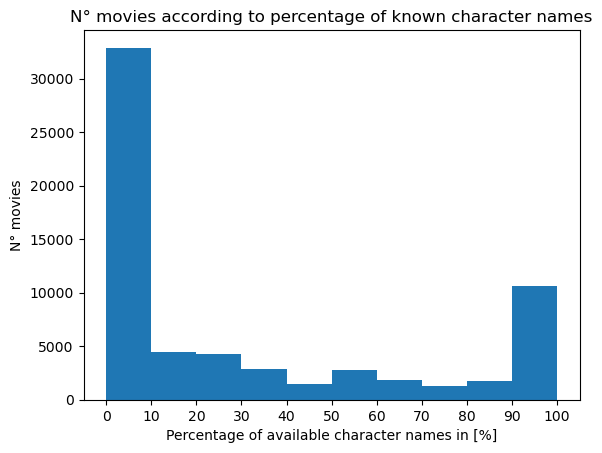

In [339]:
df_character_missing_stats['percentage_available'].hist(bins=10, grid=False)
plt.xticks(np.arange(0, 110, step=10))
plt.ylabel('N° movies')
plt.xlabel('Percentage of available character names in [%]')
plt.title('N° movies according to percentage of known character names')
plt.show()

For example: there are roughly 39 000 movies for which we have less than 10% of the character names.

In [344]:
# Let's calculate the percentage of movies for which we have at least 1 character name
# Assuming that the character name that would be available is the one of the main character.

more_1_char = df_character_missing_stats['character_names (excl. NaN)'][df_character_missing_stats['character_names (excl. NaN)'] >= 1].count()
perc_1_char = 100*more_2_char/64329

print('The total number of movies where we have at least one character name is: %d' %more_1_char)
print('The percentage of movies for which we have at least one character name is: %d' %perc_1_char, '%')

The total number of movies where we have at least one character name is: 32571
The percentage of movies for which we have at least one character name is: 50 %


In [359]:
'''Now we want to proceed to the analysis of the plots using the CoreNLP model. 
For that we first compare the plot information with the character and movie information, 
to not analyse plots we can not link to other data. The final dataframe contains only the Wikipedia Modie ID and Plot Summaries
which are related to movie and character data'''

df_char_movie_plot = pd.merge(left= df_char_movie, right= df_plot_summaries, how='inner', on= ['Wikipedia movie ID'])
df_plots_filt = df_char_movie_plot[['Wikipedia movie ID','Plot Summary']].drop_duplicates().reset_index()
df_plots_filt = df_plots_filt.drop(columns = ['index'])
df_plots_filt

Wikipedia movie ID                                       Plot Summary
0                  975900  Set in the second half of the 22nd century, th...
1                  261236  Eva, an upper class housewife, becomes frustra...
2                 2238856  The structure of the film consists of several ...
3                18296435  Serap, a young actress with a strong, lively p...
4                32456683  Otto Brosowski, a communist miner, writes to t...
...                   ...                                                ...
37773            22545667  Gracie  and Laurie  are lovers who together fo...
37774            31627556  Kara , George , and Enzo  are 3 best friends w...
37775            30553937  A daytime soap opera star has to deal with his...
37776            12476867  The movie is about a teenage girl who loves ho...
37777              913762  The story takes place in the year 2092,The Sup...

[37778 rows x 2 columns]

In [368]:
stanza.download('en') # download English model

2022-11-17 17:24:43 INFO: Downloading default packages for language: en (English) ...
2022-11-17 17:24:45 INFO: File exists: C:\Users\nerea\stanza_resources\en\default.zip
2022-11-17 17:24:49 INFO: Finished downloading models and saved to C:\Users\nerea\stanza_resources.


In [369]:
nlp = stanza.Pipeline(lang='en', processors='tokenize, mwt, pos, lemma, depparse, ner')

2022-11-17 17:24:49 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2022-11-17 17:24:49 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-11-17 17:24:50 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| ner       | ontonotes |

2022-11-17 17:24:50 INFO: Use device: cpu
2022-11-17 17:24:50 INFO: Loading: tokenize
2022-11-17 17:24:50 INFO: Loading: pos
2022-11-17 17:24:51 INFO: Loading: lemma
2022-11-17 17:24:51 INFO: Loading: depparse
2022-11-17 17:24:51 INFO: Loading: ner
2022-11-17 17:24:52 INFO: Done loading processors!


**Note:** The two following cells should not be ran locally, because of the computational cost. Instead, we used Google Colab with GPU option to run the NLP analysis and create the resulting dataset. Here we keep it for a good understanding of the workflow. The result of the analysis is in the Data folder, and we can import it directly from there.

In [ ]:
# The Analyse_Plots function is in a separated python file,
#to avoid any information not critical to the understanding of our analysis
#It is then imported from CoreNLPanalysis.py
df_NLP = Analyse_Plots(df_plots_filt)  

In [ ]:
df_NLP.to_csv(data_folder + "Plot_NLP_Analysis.csv", sep='\t', header=None)

In [372]:
# Loading the data obtained from the NLP pipeline:
df_1 = pd.read_csv(data_folder + "Plot_NLP_Analysis_0_14100.csv", sep='\t', header = None)
df_2 = pd.read_csv(data_folder + "Plot_NLP_Analysis_14101_23201.csv", sep='\t', header = None)
df_3 = pd.read_csv(data_folder + "Plot_NLP_Analysis23202-42302.csv", sep='\t', header = None)
df_1 = df_1.drop(columns=0)
df_2 = df_2.drop(columns=0)
df_3 = df_3.drop(columns=0)
clusters_df = pd.concat([df_1, df_2, df_3], ignore_index=True)
clusters_df.columns = ('Wikipedia movie ID', 'Character partial name', 'Agent Verbs', 'Patient Verbs', 'Attributes')

In [373]:
clusters_df

Wikipedia movie ID Character partial name  \
0                 23890098                 Lyosha   
1                 31186339               Primrose   
2                 31186339                Katniss   
3                 31186339                  Peeta   
4                 31186339               Haymitch   
...                    ...                    ...   
150631             8628195                  Amina   
150632             8628195                 Rehman   
150633             8628195                   Mini   
150634             6040782                 Arthur   
150635             6040782                    Joe   

                                              Agent Verbs  \
0                                                     0.0   
1                                                     0.0   
2       ['volunteers', 'survives', 'drops', 'has', 'ru...   
3       ['tribute', 'reveals', 'meant', 'forms', 'begs...   
4                                       ['able', 'warns']   
...                                                   ...   
150631                                      ['forgotten']   
150632  ['abuses', 'tries', 'states', 'forgotten', 'tr...   
150633  ['short', 'decides', 'goes', 'tolerate', 'stop...   
150634                                                0.0   
150635                                                0.0   

                                   Patient Verbs                    Attributes  
0                                            0.0                   driver taxi  
1                                     ['chosen']                           old  
2       ['gave', 'taken', 'warned', 'presented']                   sister love  
3                                            0.0     tribute mobile victorious  
4                                            0.0  victor advice able star rule  
...                                          ...                           ...  
150631                                       0.0                      daughter  
150632                                 ['gives']       lawyer honesty daughter  
150633                                       0.0         father budget wedding  
150634                                       0.0                         clerk  
150635                                       0.0                       Private  

[150636 rows x 5 columns]

In [374]:
df_char_movie_names = df_char_movie[['Wikipedia movie ID','Character name']].dropna()
df_char_movie_names['All_names'] = df_char_movie_names.groupby(['Wikipedia movie ID'], 
            as_index = True)['Character name'].transform(lambda x: ','.join(x))
df_char_movie_names = df_char_movie_names[['Wikipedia movie ID', 'All_names']].drop_duplicates()
df_char_movie_names['All_names'] = [x.strip('()').split(',') for x in df_char_movie_names['All_names']]

In [375]:
clusters_df = clusters_df.merge(df_char_movie_names, how = 'inner', on = 'Wikipedia movie ID')
clusters_df.head(3)

Wikipedia movie ID Character partial name  \
0            31186339               Primrose   
1            31186339                Katniss   
2            31186339                  Peeta   

                                         Agent Verbs  \
0                                                0.0   
1  ['volunteers', 'survives', 'drops', 'has', 'ru...   
2  ['tribute', 'reveals', 'meant', 'forms', 'begs...   

                              Patient Verbs                 Attributes  \
0                                ['chosen']                        old   
1  ['gave', 'taken', 'warned', 'presented']                sister love   
2                                       0.0  tribute mobile victorious   

                                           All_names  
0  [Foxface, Katniss Everdeen, Peeta Mellark, Eff...  
1  [Foxface, Katniss Everdeen, Peeta Mellark, Eff...  
2  [Foxface, Katniss Everdeen, Peeta Mellark, Eff...

**Note:** Same as previously, we will not run those following cells, but they are useful to understand where our data comes from.

In [378]:
def matching(col1, col2):
    if process.extractOne(col1, list(col2))[1]>80:
        res = process.extractOne(col1, list(col2))[0]    
    else:
        res = 'Not found'
    return res

clusters_df['Full_name'] = clusters_df.apply(lambda x: matching(x['Character partial name'],
                                                                            x['All_names']), axis=1)
clusters_df.tail(50)

KeyboardInterrupt: 

In [ ]:
char_df = clusters_df.loc[clusters_df['Full_name'] != 'Not found']

In [ ]:
categories = ['Agent Verbs', 'Patient Verbs', 'Attributes']

for i,cat in enumerate(categories):
    rem = char_df[cat] == '0.0'
    char_df.loc[rem, cat] = char_df.loc[rem, cat].replace('0.0', '')
char_df['All_Agent_Verbs'] = char_df.groupby(['Full_name'])['Agent Verbs'].transform(lambda x: ','.join(x))
char_df['All_Patient_Verbs'] = char_df.groupby(['Full_name'])['Patient Verbs'].transform(lambda x: ','.join(x))
char_df['All_Attributes'] = char_df.groupby(['Full_name'])['Attributes'].transform(lambda x: ','.join(x))

In [ ]:
char_df = char_df[['Wikipedia movie ID', 'Full_name', 'All_Agent_Verbs', 'All_Patient_Verbs', 'All_Attributes']]

In [ ]:
char_df.to_csv(data_folder + "Characters_Matched_DF_Clean.csv", sep='\t', header=None)

## 3- Sentiment Analysis

In [418]:
CMdf = pd.read_csv('Data/Characters_Matched_DF_Clean.csv', sep='\t',index_col = 0)
CMdf.columns = ['Wikipedia movie ID', 'Character name', 'Agent Verbs', 'Patient Verbs', 'Attributes']
CMdf.reset_index(inplace = True,drop=True)
CMdf.drop_duplicates(inplace = True)

In [419]:
CMdf = pd.merge(left= CMdf, right=df_char_movie, how='inner', on= ['Wikipedia movie ID', 'Character name'])

In [420]:
CMdf_c = CMdf[['Wikipedia movie ID','Character name','Actor gender','Agent Verbs','Patient Verbs','Attributes']]

In [428]:
#our lexicon.analyze requires a string of words with a space between them. 
# to transform current AV,PV, Attributes into required format: 

cols = ['Agent Verbs', 'Patient Verbs', 'Attributes']

for i in cols:
    CMdf_c[i] = CMdf_c[i].str.replace(',' ,' ')
    CMdf_c[i] = CMdf_c[i].str.replace('[' ,'')
    CMdf_c[i] = CMdf_c[i].str.replace(']' ,'')
    CMdf_c[i] = CMdf_c[i].str.replace("'" ,'')

C:\Users\nerea\AppData\Local\Temp\ipykernel_8748\153327755.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CMdf_c[i] = CMdf_c[i].str.replace(',' ,' ')
C:\Users\nerea\AppData\Local\Temp\ipykernel_8748\153327755.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  CMdf_c[i] = CMdf_c[i].str.replace('[' ,'')
C:\Users\nerea\AppData\Local\Temp\ipykernel_8748\153327755.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [429]:
CMdf_c.sample(10)

Wikipedia movie ID   Character name Actor gender  \
13611            24445186          Vincent            M   
3247               903383            Shrek            M   
3856               365039     Quinn Harris            M   
2859             25737142         Holbrook            M   
581              22336327             Rome            M   
10307             5377390  Tarannum 'Tanu'            F   
5359             22055483        Alma Rose            F   
12699             2492165  Blake Burroughs            M   
14582            33584636      Hans Zeisig            M   
15076              639796      El Mariachi            M   

                                             Agent Verbs  \
13611  asks  shoots  discover  follow  pays  finds  a...   
3247   infants  living  promises  goes  proceeds  tri...   
3856   makes  believes  become  fall  succeed  recove...   
2859                                                  is   
581                            believes  begins  thought   
10307                                                NaN   
5359                                                 NaN   
12699                                                NaN   
14582        meets  apolitical  makes  realizes  escapes   
15076  confronted  escapes  gives witnessed  arrives ...   

                                         Patient Verbs  \
13611                                         brings     
3247   gives  annoyed  gives  give  born  discouraged    
3856                                               NaN   
2859                                               NaN   
581                                              taken   
10307                                              NaN   
5359                                               NaN   
12699                                              NaN   
14582                                              NaN   
15076     recruited recognized  tailed  sent  ambushed   

                                              Attributes  
13611  friend classmates wife partner car killer cont...  
3247   events children plans leg decorations furnitur...  
3856   American girlfriend co-pilot adventures plane ...  
2859                                            postcard  
581                        figure father mentor run plan  
10307                                         dancer bar  
5359                                        relationship  
12699                                                son  
14582                              apolitical beard name  
15076                           addition brothers unable

### 3.1  Lexical Analysis

In [430]:
women = CMdf_c.loc[CMdf_c['Actor gender'] == 'F']
men = CMdf_c.loc[CMdf_c['Actor gender'] == 'M']

In [432]:
print('The cleaned and processed lexical information contains {} male movie characters and {} female movie characters'.format(len(men),len(women)))

The cleaned and processed lexical information contains 9927 male movie characters and 5871 female movie characters


In [433]:
women_lex_av = pd.DataFrame([lexicon.analyze(women['Agent Verbs'].str.cat(sep = ' '))])
women_lex_pv = pd.DataFrame([lexicon.analyze(women['Patient Verbs'].str.cat(sep = ' '))])
women_lex_att = pd.DataFrame([lexicon.analyze(women['Attributes'].str.cat(sep = ' '))])

In [434]:
men_lex_av = pd.DataFrame([lexicon.analyze(men['Agent Verbs'].str.cat(sep = ' '))])
men_lex_pv = pd.DataFrame([lexicon.analyze(men['Patient Verbs'].str.cat(sep = ' '))])
men_lex_att = pd.DataFrame([lexicon.analyze(men['Attributes'].str.cat(sep = ' '))])

In [435]:
gendered_lex = pd.concat([women_lex_av, women_lex_pv, women_lex_att, men_lex_av, men_lex_pv, men_lex_att], ignore_index=True)
gendered_lex.rename(index={0:"Agent Verb [F]", 1:"Patient Verb [F]", 2: "Attribute [F]" ,3:"Agent Verb [M]", 4:"Patient Verb [M]", 5: "Attribute [M]"}, inplace = True)
gendered_lex

help  office  dance  money  wedding  domestic_work  sleep  \
Agent Verb [F]     238.0    59.0  294.0   95.0    475.0           80.0  128.0   
Patient Verb [F]     3.0     0.0    0.0   20.0    168.0            0.0    1.0   
Attribute [F]     1010.0   580.0  214.0  134.0   3294.0         1095.0  201.0   
Agent Verb [M]     458.0   120.0  539.0  212.0   1033.0          185.0  172.0   
Patient Verb [M]     0.0     0.0    0.0   37.0    241.0            2.0    2.0   
Attribute [M]     1958.0   989.0  302.0  452.0   4254.0         1532.0  306.0   

                  medical_emergency   cold   hate  ...  weapon  children  \
Agent Verb [F]                225.0   34.0  201.0  ...   110.0     922.0   
Patient Verb [F]               35.0    0.0   17.0  ...    83.0     125.0   
Attribute [F]                 402.0   38.0  184.0  ...    82.0    6023.0   
Agent Verb [M]                274.0   82.0  518.0  ...   554.0    1187.0   
Patient Verb [M]               64.0    0.0   23.0  ...   200.0     199.0   
Attribute [M]                 466.0  111.0  471.0  ...   599.0    6765.0   

                  monster  ocean  giving  contentment  writing  rural  \
Agent Verb [F]       67.0   40.0   396.0         36.0     61.0   40.0   
Patient Verb [F]      0.0    0.0   194.0          0.0      5.0    0.0   
Attribute [F]        76.0   60.0   167.0         84.0    252.0  104.0   
Agent Verb [M]      118.0   95.0   790.0         69.0    197.0   70.0   
Patient Verb [M]      2.0    0.0   268.0          0.0     19.0    0.0   
Attribute [M]       260.0  385.0   281.0         77.0    323.0  161.0   

                  positive_emotion  musical  
Agent Verb [F]               571.0    159.0  
Patient Verb [F]              15.0      0.0  
Attribute [F]               1972.0    324.0  
Agent Verb [M]               926.0    365.0  
Patient Verb [M]              32.0      0.0  
Attribute [M]               2946.0    542.0  

[6 rows x 194 columns]

In [436]:
gendered_lex['Total words'] = gendered_lex.sum(axis=1)
gendered_lex

help  office  dance  money  wedding  domestic_work  sleep  \
Agent Verb [F]     238.0    59.0  294.0   95.0    475.0           80.0  128.0   
Patient Verb [F]     3.0     0.0    0.0   20.0    168.0            0.0    1.0   
Attribute [F]     1010.0   580.0  214.0  134.0   3294.0         1095.0  201.0   
Agent Verb [M]     458.0   120.0  539.0  212.0   1033.0          185.0  172.0   
Patient Verb [M]     0.0     0.0    0.0   37.0    241.0            2.0    2.0   
Attribute [M]     1958.0   989.0  302.0  452.0   4254.0         1532.0  306.0   

                  medical_emergency   cold   hate  ...  children  monster  \
Agent Verb [F]                225.0   34.0  201.0  ...     922.0     67.0   
Patient Verb [F]               35.0    0.0   17.0  ...     125.0      0.0   
Attribute [F]                 402.0   38.0  184.0  ...    6023.0     76.0   
Agent Verb [M]                274.0   82.0  518.0  ...    1187.0    118.0   
Patient Verb [M]               64.0    0.0   23.0  ...     199.0      2.0   
Attribute [M]                 466.0  111.0  471.0  ...    6765.0    260.0   

                  ocean  giving  contentment  writing  rural  \
Agent Verb [F]     40.0   396.0         36.0     61.0   40.0   
Patient Verb [F]    0.0   194.0          0.0      5.0    0.0   
Attribute [F]      60.0   167.0         84.0    252.0  104.0   
Agent Verb [M]     95.0   790.0         69.0    197.0   70.0   
Patient Verb [M]    0.0   268.0          0.0     19.0    0.0   
Attribute [M]     385.0   281.0         77.0    323.0  161.0   

                  positive_emotion  musical  Total words  
Agent Verb [F]               571.0    159.0      28410.0  
Patient Verb [F]              15.0      0.0       3505.0  
Attribute [F]               1972.0    324.0      75378.0  
Agent Verb [M]               926.0    365.0      56365.0  
Patient Verb [M]              32.0      0.0       6604.0  
Attribute [M]               2946.0    542.0     120058.0  

[6 rows x 195 columns]

In [437]:
for col in gendered_lex.columns:
    gendered_lex[col] = gendered_lex[col]/gendered_lex['Total words']


In [438]:
gendered_lex

help    office     dance     money   wedding  \
Agent Verb [F]    0.008377  0.002077  0.010348  0.003344  0.016719   
Patient Verb [F]  0.000856  0.000000  0.000000  0.005706  0.047932   
Attribute [F]     0.013399  0.007695  0.002839  0.001778  0.043700   
Agent Verb [M]    0.008126  0.002129  0.009563  0.003761  0.018327   
Patient Verb [M]  0.000000  0.000000  0.000000  0.005603  0.036493   
Attribute [M]     0.016309  0.008238  0.002515  0.003765  0.035433   

                  domestic_work     sleep  medical_emergency      cold  \
Agent Verb [F]         0.002816  0.004505           0.007920  0.001197   
Patient Verb [F]       0.000000  0.000285           0.009986  0.000000   
Attribute [F]          0.014527  0.002667           0.005333  0.000504   
Agent Verb [M]         0.003282  0.003052           0.004861  0.001455   
Patient Verb [M]       0.000303  0.000303           0.009691  0.000000   
Attribute [M]          0.012760  0.002549           0.003881  0.000925   

                      hate  ...  children   monster     ocean    giving  \
Agent Verb [F]    0.007075  ...  0.032453  0.002358  0.001408  0.013939   
Patient Verb [F]  0.004850  ...  0.035663  0.000000  0.000000  0.055350   
Attribute [F]     0.002441  ...  0.079904  0.001008  0.000796  0.002216   
Agent Verb [M]    0.009190  ...  0.021059  0.002093  0.001685  0.014016   
Patient Verb [M]  0.003483  ...  0.030133  0.000303  0.000000  0.040581   
Attribute [M]     0.003923  ...  0.056348  0.002166  0.003207  0.002341   

                  contentment   writing     rural  positive_emotion   musical  \
Agent Verb [F]       0.001267  0.002147  0.001408          0.020099  0.005597   
Patient Verb [F]     0.000000  0.001427  0.000000          0.004280  0.000000   
Attribute [F]        0.001114  0.003343  0.001380          0.026161  0.004298   
Agent Verb [M]       0.001224  0.003495  0.001242          0.016429  0.006476   
Patient Verb [M]     0.000000  0.002877  0.000000          0.004846  0.000000   
Attribute [M]        0.000641  0.002690  0.001341          0.024538  0.004514   

                  Total words  
Agent Verb [F]            1.0  
Patient Verb [F]          1.0  
Attribute [F]             1.0  
Agent Verb [M]            1.0  
Patient Verb [M]          1.0  
Attribute [M]             1.0  

[6 rows x 195 columns]